In [1]:
pip install control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.9/513.9 kB 5.7 MB/s eta 0:00:00


In [2]:
import control

In [3]:
s = control.tf('s')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_excel('FOPDT.xlsx')

In [6]:
df.describe()

,t,y
count,2501.000000,2501.000000
mean,1250.000000,21.431280
std,722.120835,9.560428
min,0.000000,0.000000
25%,625.000000,16.321156
50%,1250.000000,26.093463
75%,1875.000000,28.816572
max,2500.000000,29.644643


In [7]:
Max_t = df['t'].max()

In [8]:
Delta_t = df._get_value(1, 't') - df._get_value(0, 't')

In [9]:
Count_t = len(df['t'])

## Optimize

In [10]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [11]:
def fun(x):
    global df

    Kp = x[0]
    Tau = x[1]
    Delay = x[2]

    sys  = Kp/(Tau*s + 1)

    num, den = control.pade(Delay, n=2, numdeg=0)
    Pade = control.tf(num, den)

    FOPDT = control.series(sys, Pade)

    # Simulate step response
    t_fun, y_fun = control.step_response(FOPDT, T=Max_t, T_num=Count_t)
    df_fun = pd.DataFrame({'t_fun':t_fun, 'y_fun':y_fun})

    mse = mean_squared_error(df_fun['y_fun'], df['y'])
    return mse

In [12]:
x0 = [1.0, 1.0, 1.0]

In [13]:
bnds = ((0, None), (0, None), (0, None))

In [14]:
res = minimize(fun, x0, method='L-BFGS-B', bounds=bnds, tol=1e-6)

In [15]:
Kp_opt = res.x[0]
Tau_opt = res.x[1]
Delay_opt = res.x[2]

sys  = Kp_opt/(Tau_opt*s + 1)

num, den = control.pade(Delay_opt, n=2, numdeg=0)
Pade = control.tf(num, den)

sys_opt = control.series(sys, Pade)

In [16]:
print('Kp=', Kp_opt)
print('Tau=', Tau_opt)
print('Delay=', Delay_opt)

Kp= 29.999806686981326
Tau= 519.9819327452304
Delay= 200.00120612711595


## Plots

In [17]:
t_opt, y_opt = control.step_response(sys_opt, T=Max_t, T_num=Count_t)

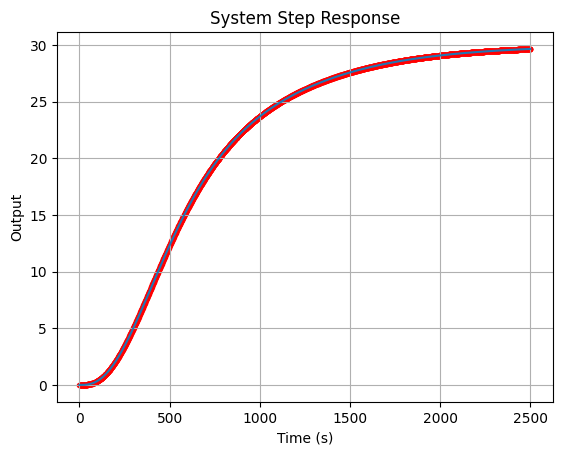

In [18]:
# Plot step response
plt.plot(t_opt,y_opt)
plt.scatter(df['t'], df['y'], marker= ".", color = "red")
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('System Step Response')
plt.grid()
plt.show()